**Oryginal article:** https://arxiv.org/abs/2009.13291

## Example - Monochromatic stationary radiative transfer in one space dimension

$$
\mu\frac{\partial}{\partial x}u(x,\mu)
+ \Big(\sigma(x)+k(x)\Big)u(x,\mu)
=
\frac{\sigma(x)}{2}\int_{-1}^1\Phi(\mu,\mu')u(z,\mu')d\mu'
$$
Where:
$$
\mu=\cos(\theta),~(x,\mu)\in[0,1]\times[-1,1]
$$
Boundary conditions:
$$
u(0,\mu) = 1,~\mu\in(0,1]
$$
$$
u(0,\mu) = 0,~\mu\in[-1,0)
$$
The coefficients and scattering kernel are:
$$
\sigma(x)=x,~k(x)=0,~\Phi(\mu,\mu')=\sum_{l=0}^{L}d_lP_l(\mu)P_l(\mu'),~d_0=1
$$
Where $P_l(\mu)$ denoting the Legendre polynomial of order $l$. The sequence of coefficients are:
$$
\vec{d} = \{1.0, 1.98398, 1.50823, 0.70075, 0.23489, 0.05133, 0.00760, 0.00048\}
$$

In [2]:
from typing import Sequence
import numpy as np

from numpy.polynomial.legendre import leggauss
from scipy.stats import qmc

import jax
from jax import grad, jit, vmap, random
import jax.numpy as jnp
from jax.scipy.special import lpmn_values
import flax.linen as nn
import optax

In [3]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.gelu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [4]:
class GenerateData:
    def __init__(self, batch_size, N_int, N_bound, seed):
        assert isinstance(batch_size, int) 
        assert isinstance(N_int, int) 
        assert isinstance(N_bound, int) 
        
        assert N_int%batch_size == 0
        assert N_bound%batch_size == 0
        
        self.batch_size = batch_size
        self.N_int = N_int
        self.N_bound = N_bound
        
        self.sampler_interior = qmc.Sobol(d=2, scramble=True, seed=seed)
        self.sampler_boundary = qmc.Sobol(d=1, scramble=True, seed=seed+1)
        self.no_batch = N_int//batch_size
        self.current = 0

    def _get_interior_points(self):
        X_int = self.sampler_interior.random(self.batch_size)
        X_int = qmc.scale(X_int, [0,-1], [1,1])
        return X_int
    
    def _get_boundary_points(self):
        mu = self.sampler_boundary.random(self.batch_size)
        mu = qmc.scale(mu, [-1], [1])
        x = np.where(mu>0., 0.0, 1.0)
        u = np.where(mu>0., 1.0, 0.0)
        return np.hstack([x, mu]), u
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self.current += 1
        if self.current <= self.no_batch:
            x_inside = self._get_interior_points()
            boundary_p, boundary_u = self._get_boundary_points()
            return {"interior_points":x_inside, 
                    "boundary_cond":{"p":boundary_p, "u":boundary_u}
                   }
        raise StopIteration

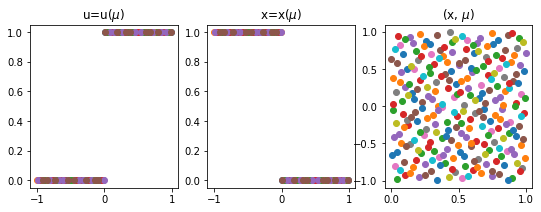

In [5]:
train_gen = GenerateData(batch_size=16, N_int=int(2**8), N_bound=int(2**8), seed=1)

fig, axs = plt.subplots(ncols=3,figsize=(9,3))
for x in train_gen:
    axs[0].scatter(x["boundary_cond"]["p"][:,1],x["boundary_cond"]["u"])
    axs[0].set_title("u=u($\mu$)")
    axs[0].grid()
    axs[1].scatter(x["boundary_cond"]["p"][:,1],x["boundary_cond"]["p"][:,0])
    axs[1].set_title("x=x($\mu$)")
    axs[1].grid()   
    axs[2].scatter(x["interior_points"][:,0],x["interior_points"][:,1])
    axs[2].set_title("(x, $\mu$)")
    axs[2].grid()

In [6]:
def legendre_jax_all(p,x):
    return lpmn_values(m=p, n=p, z=x, is_normalized=False)[0, :]

def kernel(mu, mu_prime):
    d = jnp.array([[1.0, 1.98398, 1.50823, 0.70075, 0.23489, 0.05133, 0.00760, 0.00048]]).T
    p = d.shape[0]
    
    pn_mu = legendre_jax_all(p-1, jnp.array([mu]))
    pn_mu_prime = legendre_jax_all(p-1, mu_prime)
    kn = pn_mu_prime*pn_mu*d

    return jnp.sum(kn, axis=0)

def sigma(x):
    return x

def k(x):
    return 0.0*x

In [7]:
architecture = tuple(7*[128]+[1])
model = MLP(architecture)
params = model.init(random.PRNGKey(0), jnp.ones(2,))

schedule = optax.warmup_cosine_decay_schedule(
  init_value=0.0,
  peak_value=0.01,
  warmup_steps=1024,
  decay_steps=8096-1024,
  end_value=0.0,
)

tx = optax.adam(learning_rate=schedule)
opt_state = tx.init(params)

In [9]:
from functools import partial
@partial(jit, static_argnums=(2,))
def update_step(X, params, architecture):
    lam = 0.5
    n_quad = 20
    local_model = MLP(architecture)
    def batch_loss(params):
        
        def compute_scattering(x, mu):
            mu_prime, w = np.polynomial.legendre.leggauss(n_quad)
            w = jnp.array(w)
            mu_prime = jnp.array(mu_prime)

            inputs = jnp.vstack([x*jnp.ones_like(mu_prime), mu_prime]).T
            u = jax.vmap(lambda x : local_model.apply(params, x)[0], 
                         in_axes=(0,), out_axes=0
                        )(inputs)

            kern = kernel(mu, mu_prime)

            return jnp.sum(w*u*kern)

        
        def boundary_loss(x, y):
            pred = local_model.apply(params, x)
#             return (pred - y) ** 2
            return optax.log_cosh(pred,y)
        
        def interior_loss(p):
            x = p[0]
            mu = p[1]
            u = local_model.apply(params, p)
            dudx = grad(lambda p : local_model.apply(params, p)[0])(p)[0]
        
            scat = compute_scattering(x, mu)
            
#             return ((mu*dudx + u) - sigma(x)/2*scat)**2
            return optax.log_cosh(mu*dudx + u,sigma(x)/2*scat)
        
        def loss_total(X):
            p_in = X["interior_points"]
            pu_bound = X["boundary_cond"]
            loss_int = interior_loss(p_in)
            loss_bou = boundary_loss(pu_bound["p"],pu_bound["u"])
            return loss_bou+lam*loss_int

        loss = jax.vmap(
                        loss_total, in_axes=(0,), out_axes=0,
                        )(X)
        return jnp.mean(loss)

    loss, grads = jax.value_and_grad(batch_loss)(params)
    return grads, loss

In [ ]:
train_gen = GenerateData(batch_size=int(2**6), N_int=int(2**19), N_bound=int(2**19), seed=0)
no_batch = train_gen.no_batch
history = []
for i, X in enumerate(train_gen):
    grads, loss = update_step(X, params, architecture)
    
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    history.append(loss)
    if i%(no_batch//10) == 0:
        print(f"{i}/{no_batch} : loss = {loss:8.6f}")
plt.semilogy(history)
plt.grid()

In [10]:
from flax.serialization import to_bytes, from_bytes

In [11]:
save = False
if save:
    # Save state:
    with open("jax_weights/MLP_params.bin",'bw') as f:
        f.write(to_bytes(params["params"]))
else:
    # Load state:
    with open("jax_weights/MLP_params.bin",'br') as f:
        bin_data = f.read()
        loaded_params = {"params":from_bytes(params["params"], bin_data)}

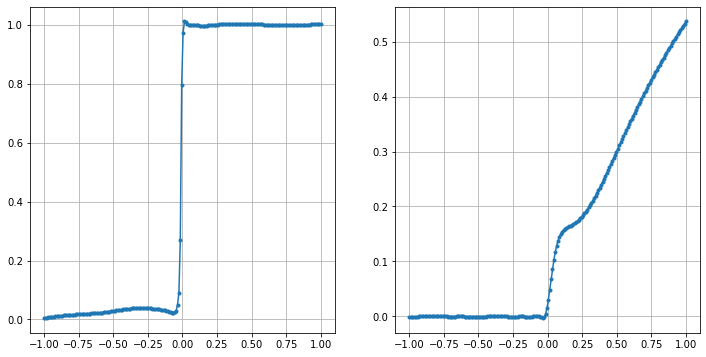

In [12]:
# Plot boundaries:
mu = np.linspace(-1,1,200)

x1 = 0.0*np.ones_like(mu)
p1 = np.vstack([x1,mu]).T
u1 = jax.vmap(lambda x : model.apply(loaded_params, x), 
             in_axes=(0,), out_axes=0
            )(p1)

x2 = 1.0*np.ones_like(mu)
p2 = np.vstack([x2,mu]).T
u2 = jax.vmap(lambda x : model.apply(loaded_params, x), 
             in_axes=(0,), out_axes=0
            )(p2)

fig, axs = plt.subplots(ncols=2,figsize=(12,6))
axs[0].plot(mu,u1,".-")
axs[0].grid()
axs[1].plot(mu,u2,".-")
axs[1].grid()

In [13]:
# Plot solution:
N = 200
X = np.linspace(0, 1, N)
MU = np.linspace(-1, 1, N)
xx, yy = np.meshgrid(X, MU)
p = np.vstack([xx.flatten(), yy.flatten()]).T

u = jax.vmap(lambda x : model.apply(loaded_params, x), 
             in_axes=(0,), out_axes=0
            )(p)

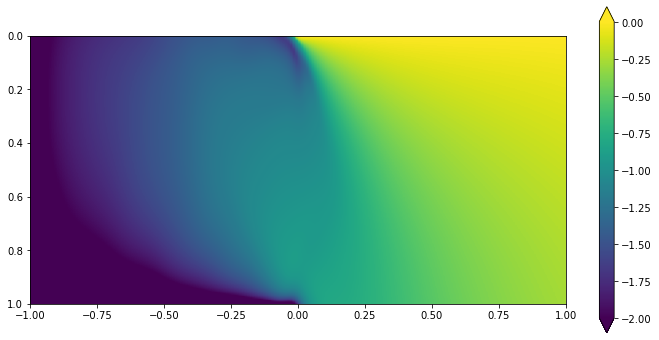

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

p = np.array(u.reshape(N,N).T)
p[p<1e-2]= 1e-2
surf = ax.imshow(np.log10(p), extent=[-1,1,1,0])
fig.colorbar(surf, ax=ax, extend='both')